In [14]:
import numpy as np
import random

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn import preprocessing
import math
from sklearn.metrics import fbeta_score
from numpy import arange
from sklearn.metrics import balanced_accuracy_score

In [15]:
metric_to_optimize = 'MCC'

In [16]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [17]:
def print_and_summarize_best_model(results,ml_results,best_models):
    ml_results = pd.concat([ml_results, results],sort=True)
    best_model_index = np.argmax(np.array(results[metric_to_optimize]))
    best_model = results.iloc[best_model_index]
    best_models = pd.concat([best_models, pd.DataFrame(best_model).transpose()],sort = True)
    
    return ml_results,best_models,best_model_index

In [18]:
def init_metrics():
    '''
    initialize the (empty) metrics structures
    :return: metrics_results
    '''
    metrics_results = {'FNR': None, 'FPR': None, 'MCC':None, 'ACC': None, 'F1score': None,'F2score': None}
    metrics_results['FNR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['FPR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['MCC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['ACC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F1score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F2score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    return metrics_results

def init_best_models():
    best_models = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return best_models

def init_ml_results():
    ml_results = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return ml_results

In [57]:
def metrics_calculation_as_binary(all_y,all_predictions):
    cm = confusion_matrix(all_y,all_predictions,labels = ['Clog','Control','Leak'])
    TP = cm[0,0]+cm[0,2]+cm[2,2]+cm[2,0] # clog or leak classified correctly
    FN = cm[0,1]+cm[2,1] #clog or leak classified as control
    FP = cm[1,0]+cm[1,2] #control classified as leak or clog
    TN = cm[1,1] #control  classified correctly
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)

    Recall =TP/(TP+FN)
    Precision=TP/(TP+FP)
#     Accuracybinary = (TP+TN)/(TP+TN+FN+FP)
    F1_Binary = 2*(Recall*Precision)/(Recall+Precision)
    F2_Binary = ((1 + 2**2) * Precision * Recall) / (2**2 * Precision + Recall)
    return FNR,FPR,F1_Binary,F2_Binary

In [77]:
def calculate_metrics(classifier_name,y_test,y_prediction_old,metrics_results):
    '''
    calculate each metric for evaluation
    :param classifier_name: name of classifier used (svm, NB, etc)
    :param y_test:
    :param y_prediction:
    :param metrics_results:
    :return:
    '''
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    from sklearn.metrics import matthews_corrcoef

    y_test = y_test.astype('category').to_numpy()
    y_test = np.array(y_test)
    y_test = np.array([item for sublist in y_test for item in sublist])
    print(y_test)
    y_prediction = np.copy(y_prediction_old)
    print(y_prediction)
    y_prediction[(y_test == 'Clog') & (y_prediction_old=="Leak")]='Clog' #CLOG CLASIFIED AS LEAK
    y_prediction[(y_test == 'Leak') & (y_prediction_old=="Clog")]='Leak'# LEAK CLASSIFIED AS CLOG
    cnf_matrix = confusion_matrix(y_test, y_prediction,
                                         labels=["Leak", "Clog", "Control"])
#     import seaborn as sns
#     plt.figure()
#     sns.heatmap(cnf_matrix, annot=True)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)

    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Fall out or false positive rate
    FPR_mal = (FP/(FP+TN))

    # False negative rate
    FNR_mal = (FN/(TP+FN))

    y_prediction_binary = np.zeros(y_test.size)
    y_prediction_binary[(y_prediction_old=="Clog") | (y_prediction_old=="Leak")]=1 #CLOG CLASIFIED AS LEAK
    y_prediction_binary[y_prediction_old == "Control"]=0
    
    y_test_binary =np.zeros(y_test.size)
    y_test_binary[(y_test == "Clog")| (y_test=="Leak")]=1
    y_test_binary[y_test == "Control"]=0
    

    TN, FP, FN, TP = confusion_matrix(y_test_binary, y_prediction_binary).ravel()

    FPR  = FP / (FP + TN)
    FNR = FN / (FN + TP)

    F1_Binary = fbeta_score(y_test_binary, y_prediction_binary, beta=1)
    F2_Binary = fbeta_score(y_test_binary, y_prediction_binary, beta=2)
    MCC = matthews_corrcoef(y_test_binary, y_prediction_binary)
    Accuracy = accuracy_score(y_test_binary, y_prediction_binary)
    balanced_ACC = balanced_accuracy_score(y_test_binary, y_prediction_binary)
    
#     FNR,FPR,F1_Binary,F2_Binary = metrics_calculation_as_binary(y_test, y_prediction)#As Binary
    
    MCC_multiclass = matthews_corrcoef(y_test, y_prediction)
#     Accuracy = accuracy_score(y_test, y_prediction)
    metrics_results['FNR'][classifier_name] = {'FNR':FNR,'Leak':FNR_mal[0],'Clog':FNR_mal[1],'MCC_multiclass':MCC_multiclass}
    metrics_results['FPR'][classifier_name] = {'FPR':FPR,'Leak':FPR_mal[0],'Clog':FPR_mal[1],'balanced_ACC':balanced_ACC}
    metrics_results['MCC'][classifier_name] = MCC
    metrics_results['ACC'][classifier_name] = Accuracy
    metrics_results['F1score'][classifier_name] = F1_Binary
    metrics_results['F2score'][classifier_name] = F2_Binary
    return metrics_results

In [45]:
def CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params):
    
    FNR_results, FPR_results, MCC_results, ACC_results,F1score_results,F2score_results = [],[],[],[],[],[]                      
    random.seed(10)
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    # K_folds:
    for train_index, test_index in skf.split(data, data_labels):
        x_train_fold, x_test_fold = data.iloc[train_index], data.iloc[test_index]
        y_train_fold, y_test_fold = data_labels.iloc[train_index], data_labels.iloc[test_index]
        if (Algorithm not in ['RF','DT']):
            if (Algorithm in('Naive Bayes','svm_linear')):
                scaler = MinMaxScaler()
            else:
                scaler = StandardScaler()
            x_train_fold = scaler.fit_transform(x_train_fold)
            x_test_fold = scaler.fit_transform(x_test_fold)
        classifier.fit(x_train_fold, y_train_fold.values.ravel())
        y_prediction = classifier.predict(x_test_fold)
        metrics_results = calculate_metrics(Algorithm,y_test_fold,y_prediction,metrics_results)
        FNR_results.append(metrics_results['FNR'][Algorithm])
        FPR_results.append(metrics_results['FPR'][Algorithm])
        MCC_results.append(metrics_results['MCC'][Algorithm])
        ACC_results.append(metrics_results['ACC'][Algorithm])
        F1score_results.append(metrics_results['F1score'][Algorithm])
        F2score_results.append(metrics_results['F2score'][Algorithm])

    results_summary = results_summary.append({'Algorithm':Algorithm,
                                              'model_index':model_index,
                                              'parameters':params,
                                              'FNR': {'FNR':sum(d['FNR'] for d in FNR_results) / len(FNR_results),
                                                     'FNR_Leak':sum(d['Leak'] for d in FNR_results) / len(FNR_results),
                                                     'FNR_Clog':sum(d['Clog'] for d in FNR_results) / len(FNR_results),
                                                     'MCC_multiclass':sum(d['MCC_multiclass'] for d in FNR_results) / len(FNR_results)}, #np.mean(FNR_results),
                                              'FPR': {'FPR':sum(d['FPR'] for d in FPR_results) / len(FPR_results),
                                                     'FPR_Leak':sum(d['Leak'] for d in FPR_results) / len(FPR_results),
                                                     'FPR_Clog':sum(d['Clog'] for d in FPR_results) / len(FPR_results),
                                                      'balanced_ACC':sum(d['balanced_ACC'] for d in FPR_results) / len(FPR_results)},
                                              'MCC': np.mean(MCC_results),
                                              'ACC': np.mean(ACC_results),
                                              'F1score': np.mean(F1score_results),
                                              'F2score': np.mean(F2score_results)},
                                             ignore_index=True)
    return results_summary

In [46]:
def train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'RF' 
    
    n_estimators = [200, 500]               # number of trees in the foreset
    max_depth = [5, 8, 10, 20]              # max number of levels in each decision tree
    criterion = ['gini', 'entropy']
    min_samples_split = [2, 5, 10, 15,20]   # min number of data points placed in a node before the node is split, used to control over-fitting
    bootstrap = [True, False]
    for n in n_estimators:
        for max in max_depth:
            for c in criterion:
                for min_sample in min_samples_split:
                    for b in bootstrap:
                        classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=n,
                                                            max_depth=max, criterion=c,min_samples_split=min_sample,bootstrap=b)  # class_weight: misclassifying the rare class is punished harsher.
                        params = {"n_estimators": n,"criterion": c,"min_samples_split":min_sample,"bootstrap":b,'max_depth':max}
                        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
                        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results

In [47]:
def train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_linear'
    kernel = 'linear'
    cs = [0.1, 1, 10, 100]
    for c in cs:
        classifier = svm.SVC(probability=True,kernel=kernel,C=c,max_iter=100000)
        params = {"kernel": kernel,"C": c}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
        model_index+=1

    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [48]:
def train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_rbf'
    kernel =  'rbf'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4]
    for c in cs:
        for gamma in gammas:
            classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,max_iter=100000)
            params = {"kernel": kernel,"C": c,'gamma':gamma}
            results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

            model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [49]:
def train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_poly'

    kernel = 'poly'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1]
    degrees = [2,3,4,5]
    for c in cs:
        for gamma in gammas:
            for degree in degrees:
                classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,degree=degree,max_iter=100000)
                params = {"kernel": kernel,"C": c,'gamma':gamma,'degree':degree}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [50]:
def train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'DT'
    
    criterion = ["gini", "entropy"]
    splitter = ["best", "random"]
    min_samples_split = [2, 5, 10, 15,20]  # min number of data points placed in a node before the node is split, used to control over-fitting
    for c in criterion:
        for s in splitter:
            for min_split in min_samples_split:
                classifier = tree.DecisionTreeClassifier(criterion=c,splitter=s,min_samples_split=min_split)
                params = {"criterion": c,"splitter": s,'min_samples_split':min_split}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [51]:
!pip install xgboost
from xgboost import XGBClassifier
def train_test_CV_XGBoost(folder_path_results, data, data_labels, metrics_results, best_models, ml_results):
    model_index = 1
    results_summary = pd.DataFrame(columns=['Algorithm', 'model_index', 'parameters',
                                            'FNR', 'FPR', 'MCC', 'ACC', 'F1score', 'F2score'])
    Algorithm = 'XGBoost'

    learning_rates = [0.01, 0.1]
    max_depths = [3, 6, 9]
    subsamples = [0.8, 1.0]
    colsample_bytrees = [0.8, 1.0]
    n_estimators = [100, 200]

    for lr in learning_rates:
        for max_depth in max_depths:
            for subsample in subsamples:
                for colsample_bytree in colsample_bytrees:
                    for n_estimator in n_estimators:
                        classifier = XGBClassifier(learning_rate=lr, max_depth=max_depth, subsample=subsample,
                                                  colsample_bytree=colsample_bytree, n_estimators=n_estimator, random_state=12)
                        params = {'learning_rate': lr, 'max_depth': max_depth, 'subsample': subsample,
                                  'colsample_bytree': colsample_bytree, 'n_estimators': n_estimator}
                        results_summary = CV_model_tunning(data, data_labels, classifier, Algorithm, model_index,
                                                           metrics_results, results_summary, params)

                        model_index += 1

    print(Algorithm, '_results_summary was created')
    results_summary.to_csv(folder_path_results + '\\' + Algorithm + '_results_summary.csv')
    ml_results, best_models, best_model_index = print_and_summarize_best_model(results_summary, ml_results, best_models)
    return ml_results, best_models, metrics_results

In [52]:
def train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'Naive Bayes'
    NB_Classifiers = [GaussianNB(), MultinomialNB()]
    # CategoricalNB()
    for NB_clf in NB_Classifiers:
        classifier = NB_clf  # create classifier
        params = {"NB_Classifiers": NB_clf}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [53]:
def train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'KNN'
    n_neighbors = range(1, 11)
    weights = ['uniform', 'distance']
    Algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
    for n in n_neighbors:
        for w in weights:
            for alg in Algorithms:
                classifier = KNeighborsClassifier(n_neighbors=n,weights=w,algorithm=alg)  # create classifier
                params = {"n_neighbors": n,'weights':w,"Algorithm":alg}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results  

In [54]:
def conduct_tunning_and_classification_for_each_family_model_CV(data,data_labels,stage):
    best_models = init_best_models()
    ml_results = init_ml_results()
    metrics_results = init_metrics()
    folder_path = 'C:\\Users\\Stav\\Desktop\\school\\2\\Research\\n\\Thesis\\\Multiclass_calssification'+stage
    folder_path_results = folder_path+'\\classifiers'
    os.makedirs(folder_path_results, exist_ok=True)
    #print('XGBoost')
    #train_test_CV_XGBoost(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('DecisionTree')
    ml_results,best_models,metrics_results = train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('RandomForest')
    ml_results,best_models,metrics_results = train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('NaiveBayes')
    ml_results,best_models,metrics_results = train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('KNN')
    ml_results,best_models,metrics_results = train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_linear')
    ml_results,best_models,metrics_results = train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_rbf')
    ml_results,best_models,metrics_results = train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_poly')
    ml_results,best_models,metrics_results = train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
   
    best_models = pd.concat([best_models.drop(['FNR','FPR'], axis=1),
               best_models['FNR'].apply(pd.Series),
               best_models['FPR'].apply(pd.Series)], axis=1)
    ml_results = pd.concat([ml_results.drop(['FNR','FPR'], axis=1),
               ml_results['FNR'].apply(pd.Series),
               ml_results['FPR'].apply(pd.Series)], axis=1)
   
    best_models = best_models.reindex(columns=['Algorithm',
                                               'model_index',
                                               'MCC',
                                               'ACC',
                                              'F1score',
                                              'F2score',
                                              'FNR',
                                              'FPR',
                                              'FNR_Leak',
                                              'FNR_Clog',
                                              'FPR_Leak',
                                              'FPR_Clog',
                                               'balanced_ACC',
                                              'MCC_multiclass']).reset_index().drop(['index'],axis=1)
    
    best_models.iloc[:,2:] = best_models.iloc[:,2:].round(5)
    best_models =best_models.set_index('Algorithm')
    best_models=best_models.T
    ml_results = ml_results.sort_values(by=[metric_to_optimize],ascending = False)

    best_models.to_csv(folder_path+'\\best_models_include_malf_metrics.csv')
    ml_results.to_csv(folder_path+'\\ml_results_include_malf_metrics.csv')
    return ml_results,best_models,metrics_results

In [55]:
def RFECV_Random_Forest(X,y):
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import matthews_corrcoef
    import sklearn.metrics as m
    from sklearn.metrics import fbeta_score, make_scorer
    ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

    average='weighted'
    # Automatically select the number of features for RFE
    # create pipeline
    rfe = RFECV(estimator=RandomForestClassifier())

    model = RandomForestClassifier()
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    
    n_scores = cross_val_score(pipeline, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    rfe.fit(X, y)
    
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n of number of selected features")
    plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
    plt.show()

    print('The optimal number of features is {}'.format(rfe.n_features_))
    features = [f for f,s in zip(X.columns, rfe.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    
    for i in range(X.shape[1]):
        print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    
    return features

In [32]:
df = pd.read_excel("C:\\Users\\Stav\\Desktop\\school\\2\\Research\\n\\DataBase-main\\results\\data_SdeDavid_afer_DataPreparation.xlsx").iloc[: , 1:] 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    763 non-null    object 
 1   Plot                    763 non-null    object 
 2   Site_Name               763 non-null    object 
 3   prctile5                763 non-null    float64
 4   max                     763 non-null    float64
 5   prctile95               763 non-null    float64
 6   std                     763 non-null    float64
 7   MTD                     763 non-null    float64
 8   median                  763 non-null    float64
 9   kurtosis                763 non-null    float64
 10  IQR                     763 non-null    float64
 11  MAD                     763 non-null    float64
 12  meanci_1                763 non-null    float64
 13  meanci_2                763 non-null    float64
 14  Diff_median_of_plot     763 non-null    fl

In [33]:
X=df.drop(['Plot','Site_Name'],axis=1).copy(True)
y= X['Type'].copy(True)
#X = X.drop(["Type"],axis=1)
X.info()
y.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    763 non-null    object 
 1   prctile5                763 non-null    float64
 2   max                     763 non-null    float64
 3   prctile95               763 non-null    float64
 4   std                     763 non-null    float64
 5   MTD                     763 non-null    float64
 6   median                  763 non-null    float64
 7   kurtosis                763 non-null    float64
 8   IQR                     763 non-null    float64
 9   MAD                     763 non-null    float64
 10  meanci_1                763 non-null    float64
 11  meanci_2                763 non-null    float64
 12  Diff_median_of_plot     763 non-null    float64
 13  Diff_mean_of_plot       763 non-null    float64
 14  Diff_std_of_plot        763 non-null    fl

Control    320
Clog       292
Leak       151
Name: Type, dtype: int64

In [83]:
y = df[["Type"]].copy(True).astype('category')
X=df.drop(["Type",'Y'],axis=1).copy(True)
random.seed(10)

data_train, data_test, data_labels_train, data_labels_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train.info()
vars_to_drop = ['Plot','Site_Name']
data_train = data_train.drop(vars_to_drop,axis=1)
print(data_labels_test)


        Type
357     Clog
259     Clog
749  Control
193     Clog
333     Clog
..       ...
643  Control
139     Leak
726  Control
602  Control
18      Leak

[229 rows x 1 columns]


In [84]:
#  y.value_counts()
print(data_labels_train.value_counts())
print(data_labels_train.info())
print(data_labels_test.value_counts())
print(data_labels_test.info())

Type   
Control    225
Clog       211
Leak        98
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 559 to 102
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Type    534 non-null    category
dtypes: category(1)
memory usage: 4.8 KB
None
Type   
Control    95
Clog       81
Leak       53
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 357 to 18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Type    229 non-null    category
dtypes: category(1)
memory usage: 2.1 KB
None


## Recursive featue elimination - cross validation based on RF

Selecting features using RFECV with RF and score F2score - as FN (miss malfunction is more important)

## Y as Categorial

In [85]:
data_labels_train['Type']
print(data_labels_test['Type'])

print(data_labels_train)

357       Clog
259       Clog
749    Control
193       Clog
333       Clog
        ...   
643    Control
139       Leak
726    Control
602    Control
18        Leak
Name: Type, Length: 229, dtype: category
Categories (3, object): ['Clog', 'Control', 'Leak']
        Type
559  Control
140     Leak
571  Control
275     Clog
521  Control
..       ...
71      Leak
106     Leak
270     Clog
435     Clog
102     Leak

[534 rows x 1 columns]


Accuracy: 0.654 (0.044)


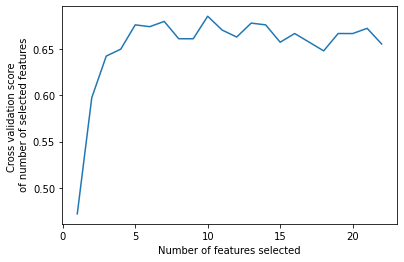

The optimal number of features is 10
The selected features are:
['prctile5', 'max', 'median', 'IQR', 'meanci_1', 'Diff_median_of_plot', 'Diff_mean_of_plot', 'Diff_mean_of_row', 'CWSI', 'CWSI_minus_CWSI_of_row']
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 11.000
Column: 3, Selected False, Rank: 12.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected False, Rank: 5.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 13.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 2.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 9.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 8.000
Column: 16, Selected False, Rank: 10.000
Column: 17, Selected False, Rank: 4.000
Column: 18, Selected False, Rank: 6.000
Column: 19, Selected False, Rank: 7.000
Col

In [38]:
random.seed(10)
features = RFECV_Random_Forest(data_train,data_labels_train['Type'])

In [39]:
features=['prctile5', 'max', 'median', 'IQR', 'meanci_1', 'Diff_median_of_plot', 'Diff_mean_of_plot', 'Diff_mean_of_row', 'CWSI', 'CWSI_minus_CWSI_of_row']

In [86]:
data_train[features].info()
#data_labels_train =data_labels_train['Type']
print(data_labels_train['Type'].astype("category"))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 559 to 102
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   prctile5                534 non-null    float64
 1   max                     534 non-null    float64
 2   median                  534 non-null    float64
 3   IQR                     534 non-null    float64
 4   meanci_1                534 non-null    float64
 5   Diff_median_of_plot     534 non-null    float64
 6   Diff_mean_of_plot       534 non-null    float64
 7   Diff_mean_of_row        534 non-null    float64
 8   CWSI                    534 non-null    float64
 9   CWSI_minus_CWSI_of_row  534 non-null    float64
dtypes: float64(10)
memory usage: 45.9 KB
559    Control
140       Leak
571    Control
275       Clog
521    Control
        ...   
71        Leak
106       Leak
270       Clog
435       Clog
102       Leak
Name: Type, Length: 534, dtype: category
Categorie

In [60]:
import sys
ml_results,best_models,metrics_results = conduct_tunning_and_classification_for_each_family_model_CV(data_train[features],
                                                                                                     data_labels_train,
                                                                                                     stage='')

DecisionTree
DT _results_summary was created
RandomForest
RF _results_summary was created
NaiveBayes
Naive Bayes _results_summary was created
KNN
KNN _results_summary was created
svm_linear
svm_linear _results_summary was created
svm_rbf
svm_rbf _results_summary was created
svm_poly


C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

svm_poly _results_summary was created


In [61]:
best_models#.sort_values(by=[metric_to_optimize],ascending=False )

Algorithm,DT,RF,Naive Bayes,KNN,svm_linear,svm_rbf,svm_poly
model_index,15,133,1,77,2,20,18
MCC,0.54894,0.623952,0.468953,0.585104,0.578734,0.629462,0.552061
ACC,0.779037,0.807127,0.729974,0.78128,0.779422,0.811642,0.779813
F1score,0.810035,0.820477,0.749043,0.788985,0.790889,0.826753,0.807102
F2score,0.813262,0.786831,0.718337,0.739424,0.750179,0.796655,0.79993
FNR,0.18388,0.23363,0.2997,0.28995,0.27314,0.22194,0.20453
FPR,0.272,0.13689,0.22933,0.12089,0.14844,0.14222,0.24178
FNR_Leak,0.14105,0.20621,0.20442,0.24516,0.15937,0.18147,0.13011
FNR_Clog,0.20372,0.24642,0.34403,0.31085,0.32596,0.24073,0.23896
FPR_Leak,0.01972,0.00458,0.07613,0.00366,0.0,0.00689,0.00504


### Evaluating model on independent data set

In [87]:
print(data_test)
test_set  = data_test.copy(True)
#data_labels_test= data_labels_test['Type'].astype('category').copy(True)
data_test = test_set[features].copy(True)
data_labels_test

    Plot  Site_Name  prctile5        max  prctile95       std        MTD  \
357    A  Sde_David  2.980036  14.651823   9.868563  2.110536  12.321602   
259    A  Sde_David  1.740006  13.041505   8.860423  2.208626  11.821369   
749    A  Sde_David  2.480044  14.129740   9.592238  2.229229  12.249094   
193    A  Sde_David  1.570093  13.056638   8.001974  2.016605  12.136410   
333    A  Sde_David  1.179916  13.070916   8.294480  2.236326  12.540749   
..   ...        ...       ...        ...        ...       ...        ...   
643    A  Sde_David  1.534998  13.219734   9.765642  2.447770  12.599644   
139    A  Sde_David  1.699938  13.181969   8.332127  2.049519  12.121952   
726    A  Sde_David  2.820038  14.578976  11.082035  2.490671  12.368637   
602    A  Sde_David  1.420060  13.168417   8.634590  2.253519  12.638281   
18     A  Sde_David  1.879974  13.453494   8.430078  2.075664  12.252785   

       median   kurtosis       IQR  ...  Diff_mean_of_plot  Diff_std_of_plot  \
357  4.

,Type
357,Clog
259,Clog
749,Control
193,Clog
333,Clog
...,...
643,Control
139,Leak
726,Control
602,Control


In [88]:
results = init_metrics()
Algorithm='SVM rbf'

params= {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
    
classifier=svm.SVC(probability=True,kernel=params['kernel'],C=params['C'],gamma=params['gamma'],max_iter=100000)

scaler = MinMaxScaler()

x_train = scaler.fit_transform(data_train[features])
x_test= scaler.fit_transform(data_test)
classifier.fit(x_train, data_labels_train.values.ravel())
y_prediction = classifier.predict(x_test)
print(len(y_prediction))
print(len(data_labels_test))
results = calculate_metrics(Algorithm,data_labels_test,y_prediction,results)

results_summary = pd.DataFrame([[Algorithm,*list(params.values()),
                                      results['FNR'][Algorithm], results['FPR'][Algorithm],
                                     results['MCC'][Algorithm], results['ACC'][Algorithm],
                                     results['F1score'][Algorithm], results['F2score'][Algorithm]]],
            columns=['Algorithm',*list(params.keys()),'FNR','FPR', 'MCC', 'ACC','F1score','F2score'])

results_summary

229
229
['Clog' 'Clog' 'Control' 'Clog' 'Clog' 'Control' 'Control' 'Leak' 'Leak'
 'Clog' 'Clog' 'Clog' 'Clog' 'Clog' 'Clog' 'Leak' 'Clog' 'Control'
 'Control' 'Control' 'Clog' 'Control' 'Control' 'Control' 'Control' 'Clog'
 'Leak' 'Control' 'Leak' 'Clog' 'Leak' 'Leak' 'Control' 'Control'
 'Control' 'Control' 'Control' 'Leak' 'Leak' 'Control' 'Control' 'Control'
 'Clog' 'Control' 'Control' 'Clog' 'Control' 'Clog' 'Clog' 'Control'
 'Control' 'Clog' 'Control' 'Clog' 'Control' 'Control' 'Control' 'Leak'
 'Leak' 'Control' 'Control' 'Control' 'Leak' 'Clog' 'Control' 'Control'
 'Clog' 'Leak' 'Leak' 'Control' 'Control' 'Clog' 'Leak' 'Clog' 'Control'
 'Clog' 'Control' 'Clog' 'Control' 'Clog' 'Control' 'Leak' 'Clog' 'Clog'
 'Clog' 'Leak' 'Control' 'Clog' 'Control' 'Control' 'Clog' 'Leak' 'Clog'
 'Clog' 'Leak' 'Control' 'Control' 'Control' 'Leak' 'Control' 'Clog'
 'Leak' 'Control' 'Leak' 'Control' 'Control' 'Control' 'Control' 'Clog'
 'Clog' 'Leak' 'Clog' 'Leak' 'Clog' 'Leak' 'Control' 'Control' 

,Algorithm,kernel,C,gamma,FNR,FPR,MCC,ACC,F1score,F2score
0,SVM rbf,rbf,10,0.1,"{'FNR': 0.2835820895522388, 'Leak': 0.20754716...","{'FPR': 0.12631578947368421, 'Leak': 0.0, 'Clo...",0.582421,0.781659,0.793388,0.745342


## Y as ordinary

In [186]:
#data_train, data_test, data_labels_train, data_labels_test = train_test_split(X, y, test_size=0.3, random_state=42)

Y_Ordinary = pd.DataFrame(data_labels_train).copy(True) 

Y_Ordinary['Y'] = 0 
Y_Ordinary.loc[Y_Ordinary['Type'] == 'Clog', 'Y'] = 0
Y_Ordinary.loc[Y_Ordinary['Type'] == 'Control', 'Y'] = 1
Y_Ordinary.loc[Y_Ordinary['Type'] == 'Leak', 'Y'] = 2

Y_Ordinary_new= pd.Series(Y_Ordinary['Type'], dtype="category")
Y_Ordinary_new= Y_Ordinary_new.cat.codes
# Y_Ordinary_new
X=data_train
y=Y_Ordinary_new
y

print(y)



#X_test = data_test
# '''
# Y_test_ordinary = pd.DataFrame(data_labels_test).copy(True) 

# Y_test_ordinary= Y_test_ordinary.replace('Clog',0)
# Y_test_ordinary=Y_test_ordinary.replace('Leak',2)
# Y_test_ordinary=Y_test_ordinary.replace('control',1)
# print(Y_test_ordinary)
# '''

# test_set2  = data_test

# data_labels_test= test_set['Type'].astype('category').copy(True)
# print(data_labels_test)
# # data_test = test_set[features].copy(True)
# # data_labels_test

559    1
140    2
571    1
275    0
521    1
      ..
71     2
106    2
270    0
435    0
102    2
Length: 534, dtype: int8


Accuracy: 0.636 (0.045)


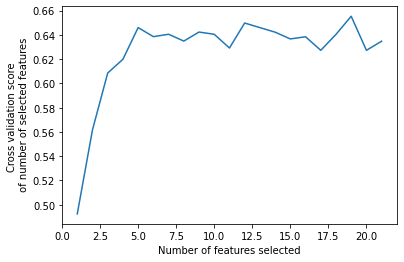

The optimal number of features is 19
The selected features are:
['mean', 'min', 'prctile5', 'prctile95', 'MTD', 'median', 'skewness', 'MAD', 'meanci_1', 'meanci_2', 'Diff_mean_of_plot', 'Diff_std_of_plot', 'Diff_median_of_row', 'Diff_std_of_row', 'mean_second_ring', 'mean_third_ring', 'mean_core', 'CWSI', 'CWSI_minus_CWSI_of_row']
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 3.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 2.000
Column: 16, Selected True, Rank: 1.000
Column: 17, 

In [187]:
features = RFECV_Random_Forest(X,y)

Accuracy: 0.448 (0.034)


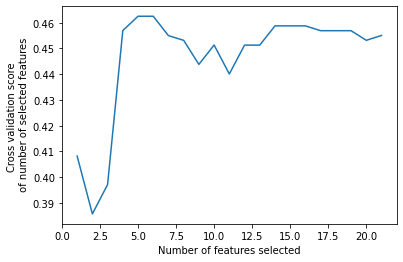

The optimal number of features is 5
The selected features are:
['min', 'prctile5', 'std', 'MTD', 'Diff_std_of_row']
Column: 0, Selected False, Rank: 10.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 9.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected False, Rank: 11.000
Column: 7, Selected False, Rank: 7.000
Column: 8, Selected False, Rank: 13.000
Column: 9, Selected False, Rank: 8.000
Column: 10, Selected False, Rank: 16.000
Column: 11, Selected False, Rank: 6.000
Column: 12, Selected False, Rank: 17.000
Column: 13, Selected False, Rank: 5.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 12.000
Column: 16, Selected False, Rank: 2.000
Column: 17, Selected False, Rank: 3.000
Column: 18, Selected False, Rank: 14.000
Column: 19, Selected False, Rank: 15.000
Column: 20, Selected False, Rank: 4.000


In [69]:
import random
random.seed(10)
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import matthews_corrcoef
import sklearn.metrics as m
import mord as mor

from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

average='weighted'
# Automatically select the number of features for RFE
# create pipeline
rfe = RFECV(estimator= mor.LogisticIT())

model =mor.LogisticIT()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)

n_scores = cross_val_score(pipeline, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
rfe.fit(X, y)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
plt.show()

print('The optimal number of features is {}'.format(rfe.n_features_))
features2 = [f for f,s in zip(X.columns, rfe.support_) if s]
print('The selected features are:')
print ('{}'.format(features2))

for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

In [188]:
features2 = ['mean', 'min', 'prctile5', 'prctile95', 'MTD', 'median', 'skewness', 'MAD', 'meanci_1', 'meanci_2', 'Diff_mean_of_plot', 'Diff_std_of_plot', 'Diff_median_of_row', 'Diff_std_of_row', 'mean_second_ring', 'mean_third_ring', 'mean_core', 'CWSI', 'CWSI_minus_CWSI_of_row']
data_train[features2].info()
data_train2 = data_train[features2]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 559 to 102
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean                    534 non-null    float64
 1   min                     534 non-null    float64
 2   prctile5                534 non-null    float64
 3   prctile95               534 non-null    float64
 4   MTD                     534 non-null    float64
 5   median                  534 non-null    float64
 6   skewness                534 non-null    float64
 7   MAD                     534 non-null    float64
 8   meanci_1                534 non-null    float64
 9   meanci_2                534 non-null    float64
 10  Diff_mean_of_plot       534 non-null    float64
 11  Diff_std_of_plot        534 non-null    float64
 12  Diff_median_of_row      534 non-null    float64
 13  Diff_std_of_row         534 non-null    float64
 14  mean_second_ring        534 non-null    

In [189]:
print(X,y)

         mean       min  prctile5  prctile95       std        MTD    median  \
559  3.762650  0.960154  1.667957   8.803800  2.093554  12.200603  3.270008   
140  3.762712  1.280071  1.583964   8.867429  2.173597  11.740597  3.130230   
571  3.437542  0.360171  1.149818   9.484619  2.450707  12.808708  2.629939   
275  3.172213  0.760146  1.284033   8.245013  2.253784  14.032244  2.560487   
521  3.976561  1.290052  2.040066   9.077546  2.155338  12.080830  3.190046   
..        ...       ...       ...        ...       ...        ...       ...   
71   2.940667  0.490139  0.942129   9.345879  2.462194  12.702629  2.119646   
106  2.467225  0.100651  0.780039   8.283126  2.312168  13.137623  1.679945   
270  4.296501  1.640247  2.079993   9.270044  2.201083  13.023853  3.680190   
435  4.944371  2.650152  2.950258  10.013322  2.110692  12.131794  4.285005   
102  4.316698  2.160196  2.740034  10.052710  2.212001  11.710114  3.429975   

     skewness       MAD  meanci_1  ...  Diff_mean_o

In [211]:
ml_results2,best_models2,metrics_results2 = conduct_tunning_and_classification_for_each_family_model_CV(data_train[features2],data_labels_train,stage='\\Features_of_Y_as_ordinary')

DecisionTree
DT _results_summary was created
RandomForest
RF _results_summary was created
NaiveBayes
Naive Bayes _results_summary was created
KNN
KNN _results_summary was created
svm_linear


C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


svm_linear _results_summary was created
svm_rbf
svm_rbf _results_summary was created
svm_poly


C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Stav\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

svm_poly _results_summary was created


In [212]:
best_models2#.sort_values(by=['F2score'],ascending=False )

Algorithm,DT,RF,Naive Bayes,KNN,svm_linear,svm_rbf,svm_poly
model_index,2,34,2,77,2,11,14
MCC,0.49697,0.600474,0.455109,0.563892,0.571675,0.599623,0.551944
ACC,0.753976,0.789166,0.727741,0.771208,0.775662,0.774181,0.770428
F1score,0.787699,0.797385,0.754469,0.779905,0.785288,0.76904,0.786981
F2score,0.788617,0.749387,0.73516,0.731667,0.741496,0.693203,0.755238
FNR,0.21029,0.27891,0.27634,0.29696,0.28415,0.34948,0.26335
FPR,0.29511,0.11733,0.26667,0.13511,0.14222,0.056,0.18311
FNR_Leak,0.14284,0.20147,0.16516,0.20768,0.15474,0.22389,0.17095
FNR_Clog,0.24175,0.31455,0.32793,0.33829,0.34408,0.40762,0.30629
FPR_Leak,0.03213,0.01377,0.0,0.0055,0.0,0.0,0.0


## Evaluating model on independent data set

In [213]:


data_test2=test_set[features2].copy(True)
data_labels_test2 = data_labels_test
data_labels_train2 = data_labels_train
print(data_labels_test2)


357       Clog
259       Clog
749    Control
193       Clog
333       Clog
        ...   
643    Control
139       Leak
726    Control
602    Control
18        Leak
Name: Type, Length: 229, dtype: category
Categories (3, object): ['Clog', 'Control', 'Leak']


In [217]:
results2 = init_metrics()
Algorithm='RF'
params = {'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 5, 'bootstrap': False, 'max_depth': 8}
#classifier=svm.SVC(probability=True,kernel=params['kernel'],C=params['c'],gamma=params['gamma'],max_iter=100000)
classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=200,
                                                            max_depth=8, criterion='entropy',min_samples_split=5,bootstrap=False) 
#scaler = MinMaxScaler()
#x_train2 = scaler.fit_transform(data_train2)
#x_test2= scaler.fit_transform(data_test2)

classifier.fit(data_train[features2],data_labels_train.values.ravel())
y_prediction2 = classifier.predict(data_test2)
print(data_labels_test2)
print(y_prediction2)
results2 = calculate_metrics(Algorithm,data_labels_test2,y_prediction2,results2)

results_summary = pd.DataFrame([[Algorithm,*list(params.values()),
                                      results2['FNR'][Algorithm], results2['FPR'][Algorithm],
                                     results2['MCC'][Algorithm], results2['ACC'][Algorithm],
                                     results2['F1score'][Algorithm], results2['F2score'][Algorithm]]],
            columns=['Algorithm',*list(params.keys()),'FNR','FPR', 'MCC', 'ACC','F1score','F2score'])

results_summary

357       Clog
259       Clog
749    Control
193       Clog
333       Clog
        ...   
643    Control
139       Leak
726    Control
602    Control
18        Leak
Name: Type, Length: 229, dtype: category
Categories (3, object): ['Clog', 'Control', 'Leak']
['Control' 'Control' 'Control' 'Leak' 'Leak' 'Control' 'Control' 'Leak'
 'Leak' 'Clog' 'Control' 'Clog' 'Leak' 'Leak' 'Control' 'Leak' 'Clog'
 'Control' 'Control' 'Control' 'Control' 'Control' 'Control' 'Control'
 'Control' 'Clog' 'Clog' 'Control' 'Leak' 'Leak' 'Control' 'Control'
 'Control' 'Control' 'Control' 'Control' 'Control' 'Leak' 'Leak' 'Clog'
 'Control' 'Control' 'Control' 'Control' 'Control' 'Clog' 'Control' 'Leak'
 'Control' 'Control' 'Control' 'Clog' 'Control' 'Clog' 'Clog' 'Control'
 'Control' 'Control' 'Leak' 'Control' 'Control' 'Control' 'Clog' 'Clog'
 'Control' 'Control' 'Clog' 'Control' 'Clog' 'Control' 'Control' 'Leak'
 'Control' 'Leak' 'Control' 'Leak' 'Control' 'Leak' 'Control' 'Clog'
 'Control' 'Clog' 'Clog' 'Cl

,Algorithm,n_estimators,criterion,min_samples_split,bootstrap,max_depth,FNR,FPR,MCC,ACC,F1score,F2score
0,RF,200,entropy,5,False,8,"{'FNR': 0.22388059701492538, 'Leak': 0.2264150...","{'FPR': 0.14736842105263157, 'Leak': 0.0227272...",0.619855,0.80786,0.825397,0.795107
